## Skin cancer classification web application, Digital System Project  
***
#### Introduction to project
***
This projects aim is to create a easy to access online web tool with the ability to detect, within a percrentage accuracy, 3 possible cacnerous types of skin leisons, Users are able to submit an image of a skin lesion or a url (of an image of the skin leison) adn gather an instant prediction.  

***
#### imports and libraries 


In [35]:
# matplotlib related imports
import matplotlib.pyplot as plt  # for data visualization

# seaborn for statistical data visualization
import seaborn as sns

# numpy, pandas related imports
import numpy as np  # for numerical computations
np.random.seed(123) # setting a random seed for reproducibility of results
import pandas as pd # for data manipulation and analysis

# os and glob for file and directory operations
import os              # for interacting with the OS
from glob import glob  # for creating lists of file paths matching a pattern

# PIL for image operations
from PIL import Image

# for visualisation of true false confusion matrix
import itertools

# scikit-learn related imports
from sklearn.metrics import confusion_matrix         # for creating a confusion matrix
from sklearn.model_selection import train_test_split # for splitting data into training and test sets
from sklearn.metrics import classification_report

# tensorflow related import
import tensorflow as tf

# keras related imports
import keras                                        # for deep learning
from keras.models import Sequential, load_model     # for creating a sequential model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, LeakyReLU  # various layers for the model
from keras.optimizers import  Adam              # for the Adam optimizer
from keras.callbacks import ReduceLROnPlateau       # to reduce learning rate when a metric has stopped improving
from keras.preprocessing.image import ImageDataGenerator # for real-time data augmentation
from keras.utils import to_categorical              # for converting class vector (integers) to binary class matrix


### Data Preprocessing 

this is used to create a Dataframe for the data and also cleaning, making the data much more useable and readable 

***


Insuring correct directory

In [36]:
os.listdir('../.input')

['category_samples.png',
 'HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv',
 'model.h5']

Setting directory with os path as var for use in dataframe

In [37]:
# Set the directory path for the skin image dataset
base_skin_dir = os.path.join('..', '.input')
print(base_skin_dir)

..\.input


Creating a dictionary of the image paths for the dataset 

In [38]:
# Create a dictionary that maps each image ID to its respective file path.
# We use a dictionary comprehension where the keys are the base names of the images 
# (i.e., the image file name without the .jpg extension) and the values are the image paths.
# The glob function is used to get all .jpg image file paths from the base_skin_dir.

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

Creation of a Dictionary for the leison types found in the dataset

In [39]:
# Create a dictionary that maps each lesion type code to its full name. 
# This is useful for displaying more human-friendly labels later on.
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Reading CSV into the dataframe

In [40]:
df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

adding further creating new columns in the data frame we have made from the previous dictionaries for the image path and the leison type 

In [41]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

unique_cell_type_idxs = df['cell_type_idx'].unique()
for idx in unique_cell_type_idxs:
    cell_type = df[df['cell_type_idx'] == idx]['cell_type'].iloc[0]
    print(f"Index: {idx}, Cell Type: {cell_type}")


Index: 2, Cell Type: Benign keratosis-like lesions 
Index: 4, Cell Type: Melanocytic nevi
Index: 3, Cell Type: Dermatofibroma
Index: 5, Cell Type: Melanoma
Index: 6, Cell Type: Vascular lesions
Index: 1, Cell Type: Basal cell carcinoma
Index: 0, Cell Type: Actinic keratoses


displaying the dataframe to ensure we have correctly read the columns and added new columns we have made into the dataframe

In [42]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  ..\.input\HAM10000_images_part_1\ISIC_0027419.jpg   
1  ..\.input\HAM10000_images_part_1\ISIC_0025030.jpg   
2  ..\.input\HAM10000_images_part_1\ISIC_0026769.jpg   
3  ..\.input\HAM10000_images_part_1\ISIC_0025661.jpg   
4  ..\.input\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

Checking for NULL data values in the dataset so we can replace them

In [43]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

/\ after finding the null values in age above we move on to create averages to replace these variables as they cannot be read by the model as NULL /\

***

below we follow on from this creating means of the age from the NULL values

In [44]:
df['age'].fillna((df['age'].mean()), inplace=True)

Re-checking for null variables in the dataset

In [45]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

Loading and resizing of images into the dataframe

In [46]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

Checking if the dataframe is updated with the image column

In [47]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  ..\.input\HAM10000_images_part_1\ISIC_0027419.jpg   
1  ..\.input\HAM10000_images_part_1\ISIC_0025030.jpg   
2  ..\.input\HAM10000_images_part_1\ISIC_0026769.jpg   
3  ..\.input\HAM10000_images_part_1\ISIC_0025661.jpg   
4  ..\.input\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_type_idx  \
0  Benign keratosis-like lesions               2   
1  Benign keratosis-like lesions               2   
2  Benign keratosis-like lesions               2   
3  Benign keratosis-like lesions               2   
4  Benign keratosis-like lesions               2   

                                               image  
0  [[[190, 153, 194], [192, 154, 196], [191, 153,...  
1  [[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3...  
2  [[[185, 127, 137], [189, 133, 147], [194, 136,...  
3  [[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5...  
4  [[[134, 90, 113], [147, 102, 125], [159, 115, ...

checcking the value coutns of the images

In [48]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    10015
Name: count, dtype: int64

This area takes a random image from each of the cell types and displays them indivdually for viewing / saving / testing later on in the web application.

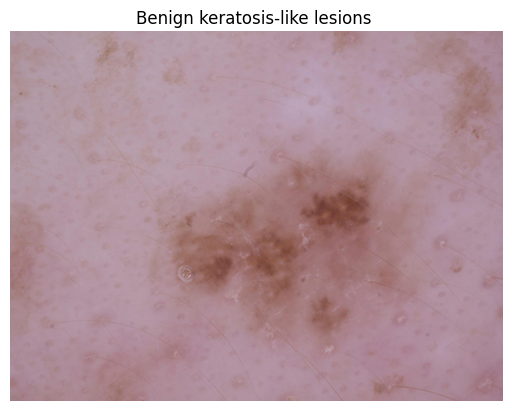

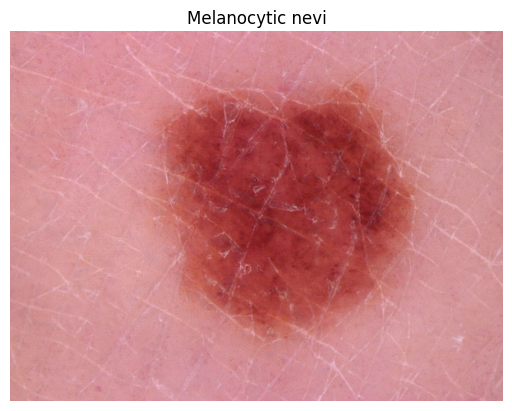

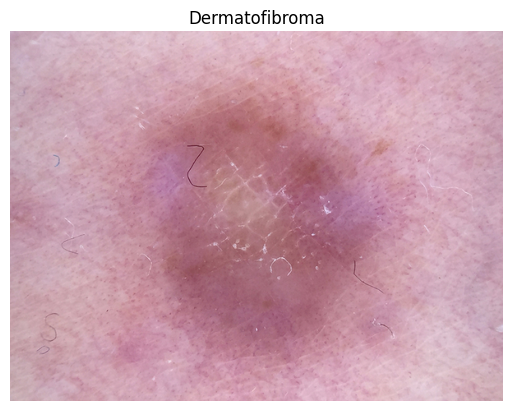

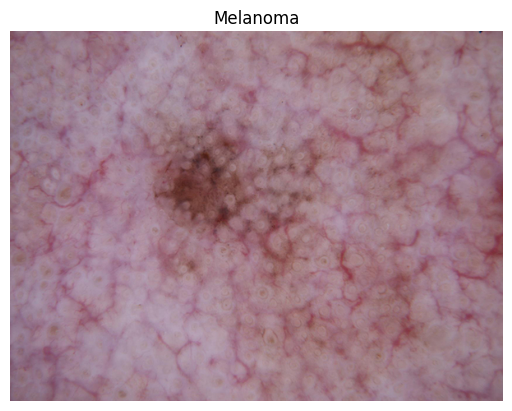

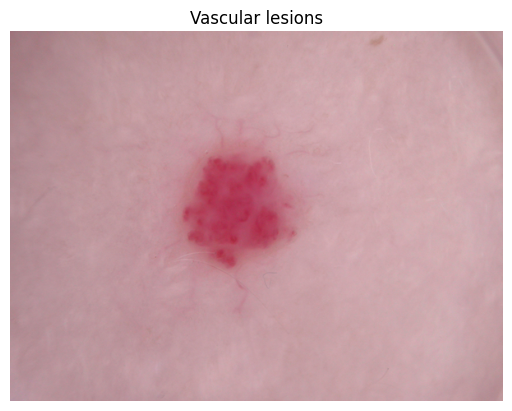

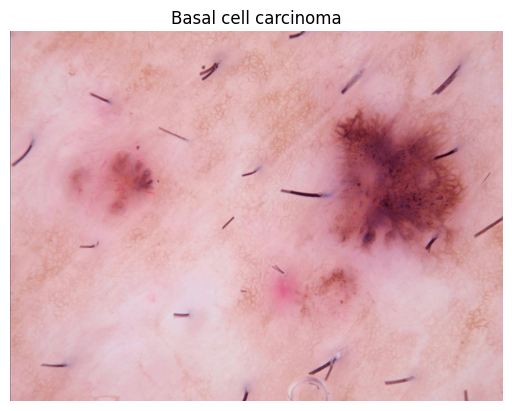

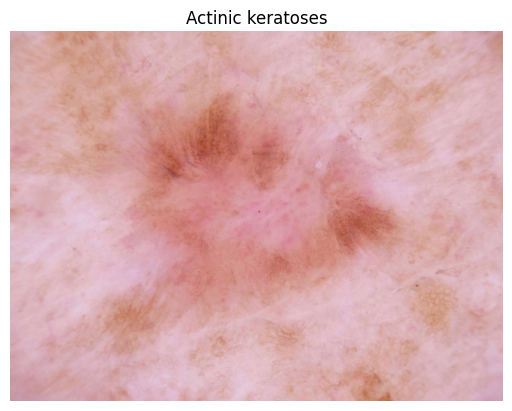

In [49]:
for cell_type in df['cell_type'].unique():
    # Filter the DataFrame for each type and randomly sample one entry
    random_sample = df[df['cell_type'] == cell_type].sample(1)
    
    # Display the image and title for each sample
    fig, ax = plt.subplots()
    image = Image.open(random_sample['path'].values[0])
    ax.imshow(image)
    ax.set_title(random_sample['cell_type'].values[0])
    ax.axis('off')
    plt.show()

#### EDA 
EDAs (Exploratory Data Analysis) are neccesary for understanding, cleaning, analysing, visualising and performance of the model.
These investigations into the data set provide neccesary information for how we build, trian and improve upon our models 
***

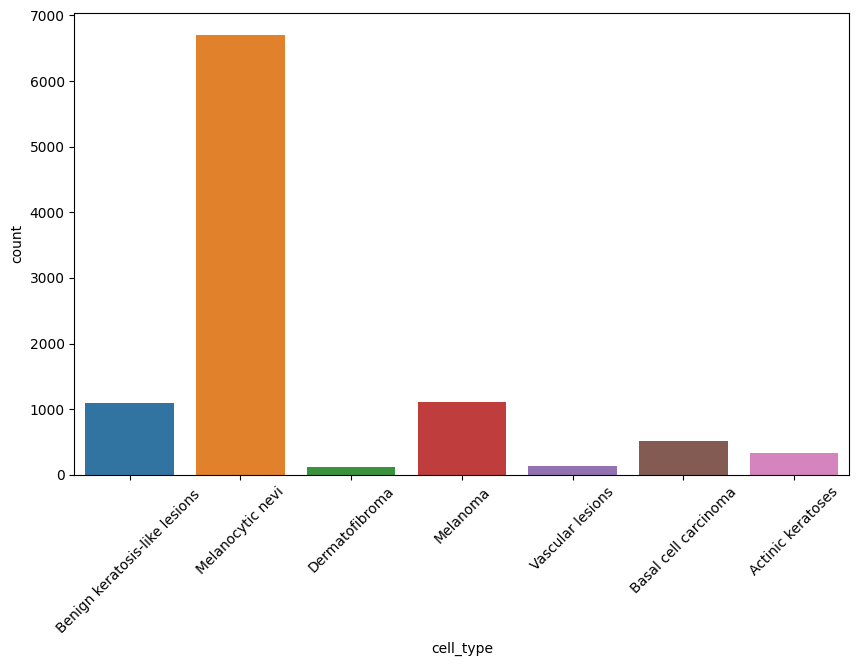

In [50]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='cell_type', data=df)
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='age', ylabel='Count'>

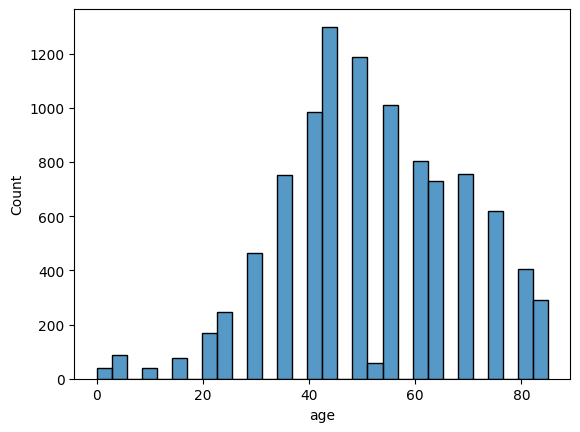

In [51]:
sns.histplot(df['age'], bins=30)


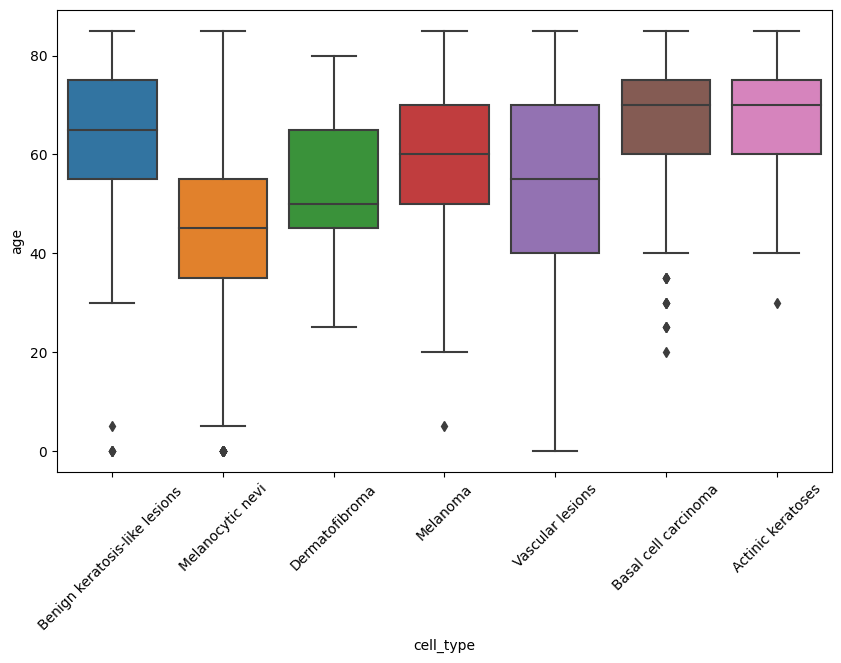

In [52]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x='cell_type', y='age', data=df)
plt.xticks(rotation=45)
plt.show()

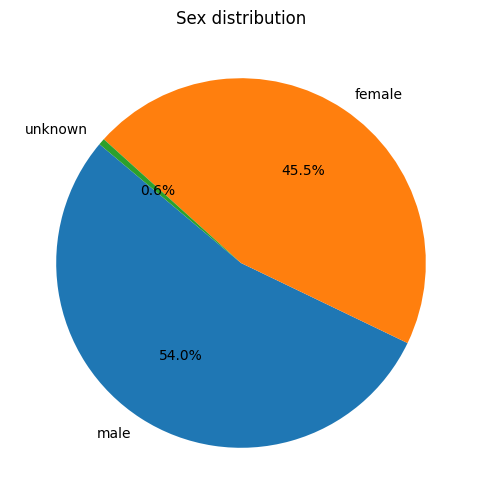

In [53]:
sex_count = df['sex'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(sex_count, labels=sex_count.index, autopct='%1.1f%%', startangle=140)
plt.title('Sex distribution')
plt.show()

c:\Users\ethan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


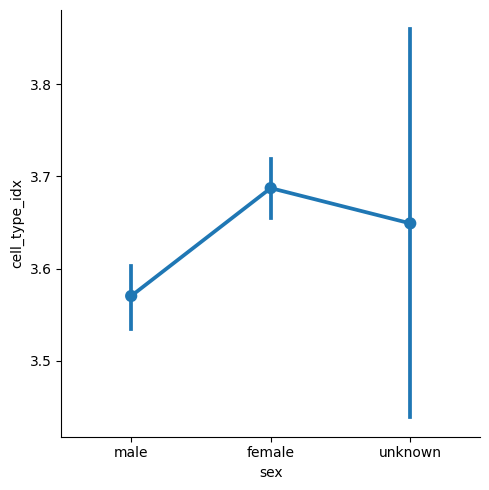

In [54]:
sns.catplot(x = 'sex', y = 'cell_type_idx',data=df, kind = "point")


In [55]:
df = df[df['sex'] != 'unknown']
df['sex'].unique()


array(['male', 'female'], dtype=object)

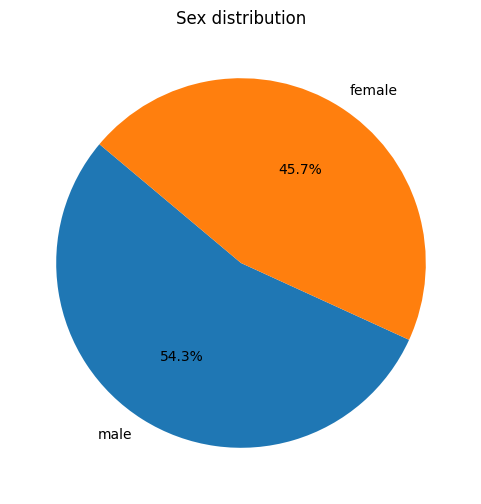

In [56]:
sex_count = df['sex'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(sex_count, labels=sex_count.index, autopct='%1.1f%%', startangle=140)
plt.title('Sex distribution')
plt.show()

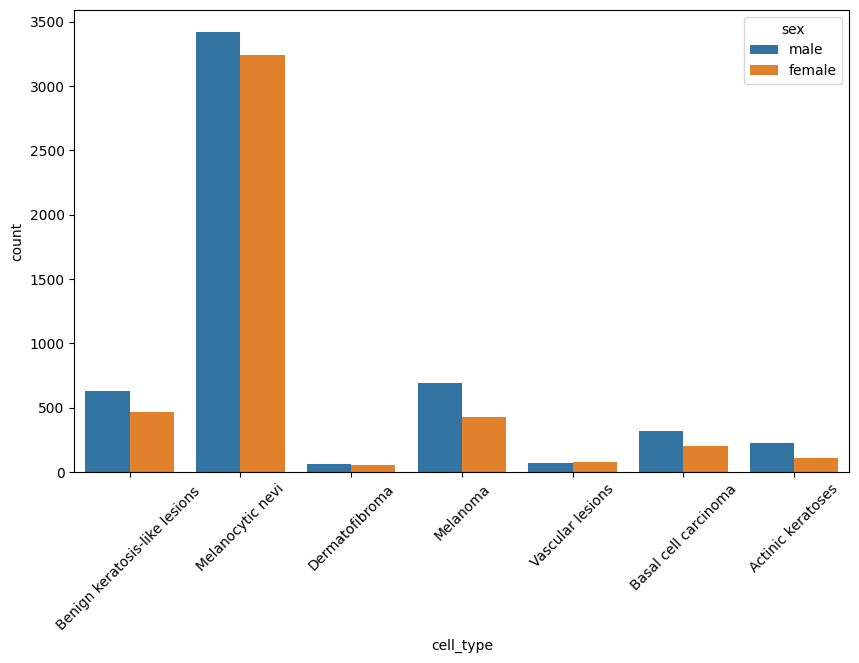

In [57]:

plt.figure(figsize=(10,6))
ax = sns.countplot(x='cell_type', hue='sex', data=df)
plt.xticks(rotation=45)
plt.show()


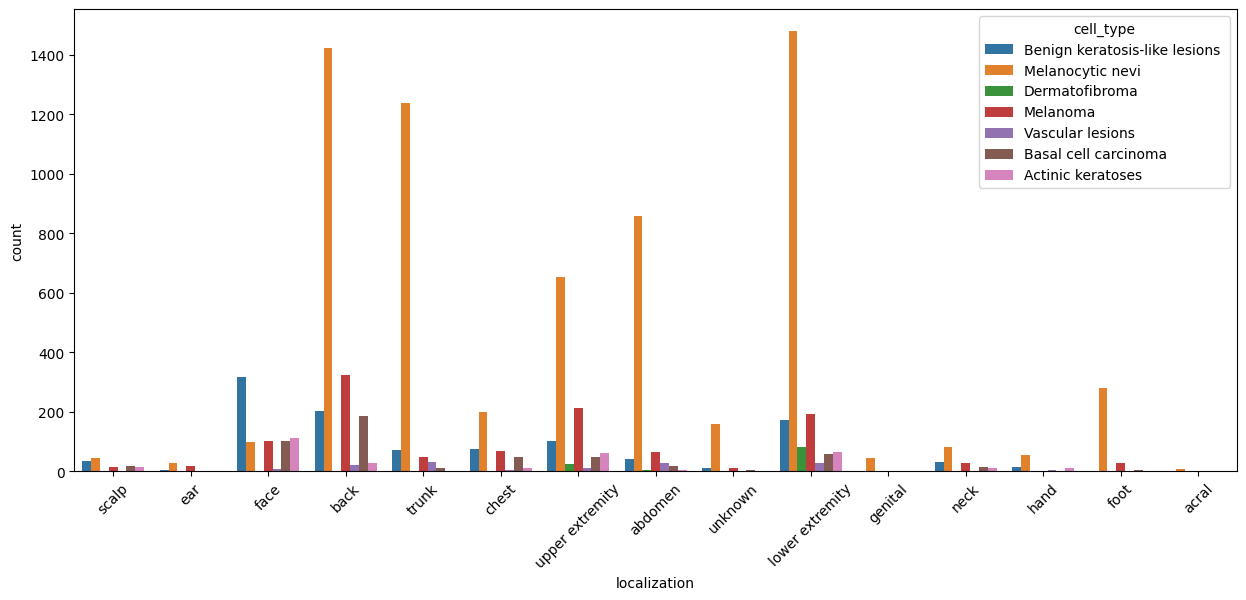

In [58]:
plt.figure(figsize=(15,6))
sns.countplot(x='localization', hue='cell_type', data=df)
plt.xticks(rotation=45);


### Model Building
***


In [59]:
features = df.drop(columns=['cell_type_idx'], axis=1)
target = df['cell_type_idx']

In [60]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20, random_state=12)

In [61]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

In [62]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

In [63]:
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

In [64]:
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

In [65]:
# Perform one-hot encoding on the labels
unique_labels = np.unique(y_train_o)
for i, label in enumerate(unique_labels):
    print(f"Index: {i}, Label: {label}")
    
y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)

Index: 0, Label: 0
Index: 1, Label: 1
Index: 2, Label: 2
Index: 3, Label: 3
Index: 4, Label: 4
Index: 5, Label: 5
Index: 6, Label: 6


In [66]:
# Instantiate your ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Fit your generator on your training data
datagen.fit(x_train)


In [67]:
# Set the CNN model
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding='Same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, (3, 3), padding='Same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [68]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 75, 100, 64)       1792      
                                                                 
 batch_normalization_5 (Bat  (None, 75, 100, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 75, 100, 64)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 100, 64)       36928     
                                                                 
 batch_normalization_6 (Bat  (None, 75, 100, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 75, 100, 64)      

In [69]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [70]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=10),
                    epochs=40, 
                    steps_per_epoch=x_train.shape[0] // 10,
                    validation_data=(x_test, y_test),
                    callbacks=[learning_rate_reduction])

Epoch 1/40
796/796 [==============================] - 351s 438ms/step - loss: 1.0925 - accuracy: 0.6258 - val_loss: 0.9951 - val_accuracy: 0.6918 - lr: 0.0010
Epoch 2/40
796/796 [==============================] - 375s 472ms/step - loss: 0.9612 - accuracy: 0.6604 - val_loss: 0.7940 - val_accuracy: 0.7073 - lr: 0.0010
Epoch 3/40
796/796 [==============================] - 368s 463ms/step - loss: 0.9126 - accuracy: 0.6701 - val_loss: 0.8054 - val_accuracy: 0.7003 - lr: 0.0010
Epoch 4/40
796/796 [==============================] - 367s 461ms/step - loss: 0.8867 - accuracy: 0.6806 - val_loss: 0.7343 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 5/40
796/796 [==============================] - 372s 467ms/step - loss: 0.8665 - accuracy: 0.6875 - val_loss: 0.7578 - val_accuracy: 0.7144 - lr: 0.0010
Epoch 6/40
796/796 [==============================] - 363s 456ms/step - loss: 0.8519 - accuracy: 0.6899 - val_loss: 0.7333 - val_accuracy: 0.7309 - lr: 0.0010
Epoch 7/40
796/796 [==========================

KeyboardInterrupt: 

In [ ]:
eval_score = model.evaluate(x_test, y_test)

print("Test loss:", eval_score[0])
print("Test accuracy:", eval_score[1])

63/63 [==============================] - 13s 213ms/step - loss: 0.6348 - accuracy: 0.7676
Test loss: 0.6348276138305664
Test accuracy: 0.7675702571868896


In [ ]:
y_pred_CNN = (model.predict(x_test) > 0.5).astype("int32")
print(y_pred_CNN)

63/63 [==============================] - 13s 210ms/step
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]


In [ ]:
y_pred = model.predict(x_test)

# The model will output probabilities for each class, 
# so you'll need to convert these to a single prediction per example
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the classification report
report = classification_report(y_true, y_pred_classes, target_names=lesion_type_dict.values())
print(report)

63/63 [==============================] - 13s 209ms/step
                                precision    recall  f1-score   support

              Melanocytic nevi       0.42      0.43      0.42        70
                      Melanoma       0.45      0.62      0.52        89
Benign keratosis-like lesions        0.51      0.51      0.51       197
          Basal cell carcinoma       1.00      0.08      0.15        25
             Actinic keratoses       0.87      0.92      0.89      1365
              Vascular lesions       0.55      0.33      0.41       214
                Dermatofibroma       0.57      0.72      0.64        32

                      accuracy                           0.77      1992
                     macro avg       0.62      0.51      0.51      1992
                  weighted avg       0.76      0.77      0.76      1992



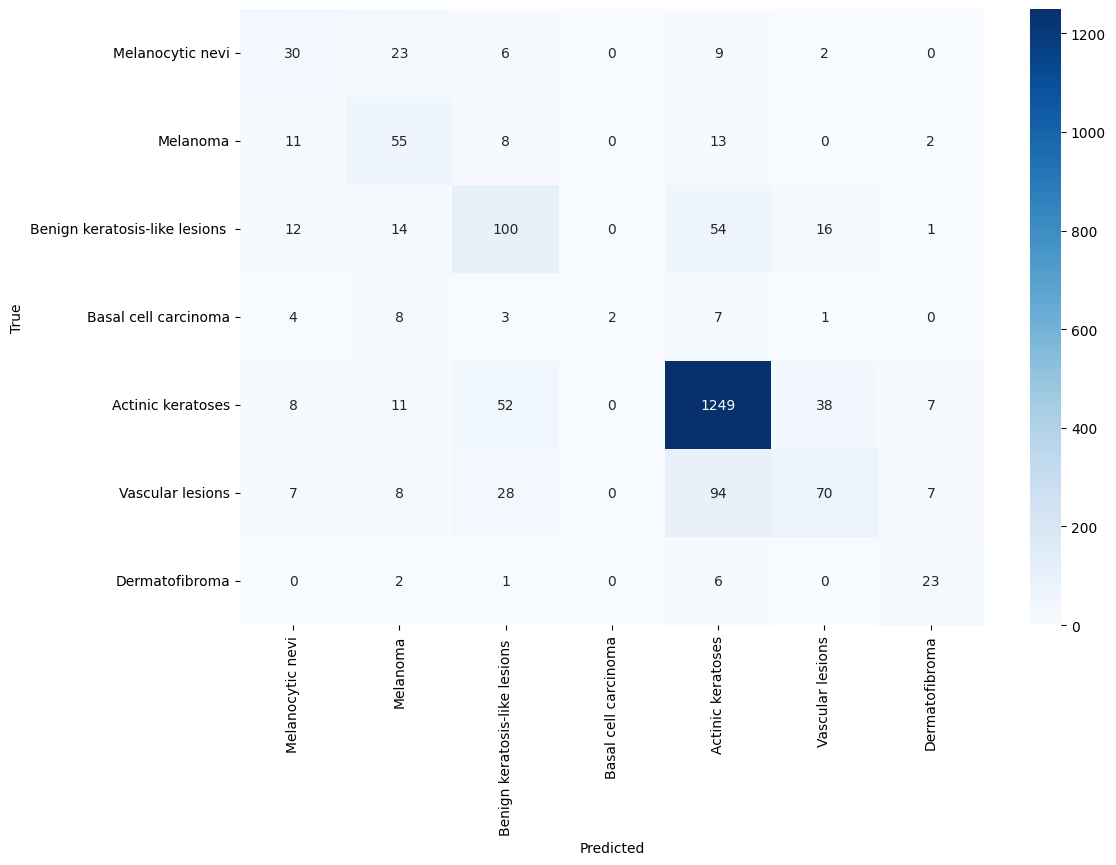

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=lesion_type_dict.values(), yticklabels=lesion_type_dict.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Save the model
model.save('.my_model.h5')

c:\Users\ethan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the model from the file
loaded_model = load_model('my_model.h5')

# Now you can use `loaded_model` to predict, evaluate, etc.
# For example:
eval_score = loaded_model.evaluate(x_test, y_test)

print("Test loss:", eval_score[0])
print("Test accuracy:", eval_score[1])

63/63 [==============================] - 15s 234ms/step - loss: 0.6348 - accuracy: 0.7676
Test loss: 0.6348276138305664
Test accuracy: 0.7675702571868896


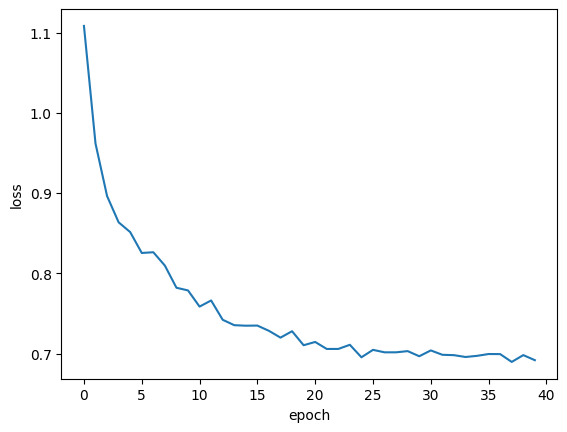

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

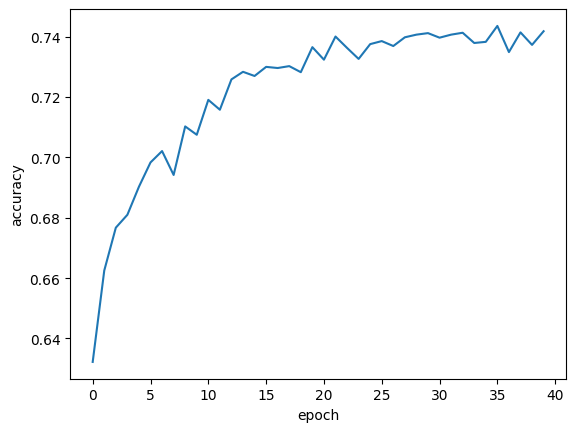

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

63/63 [==============================] - 13s 208ms/step


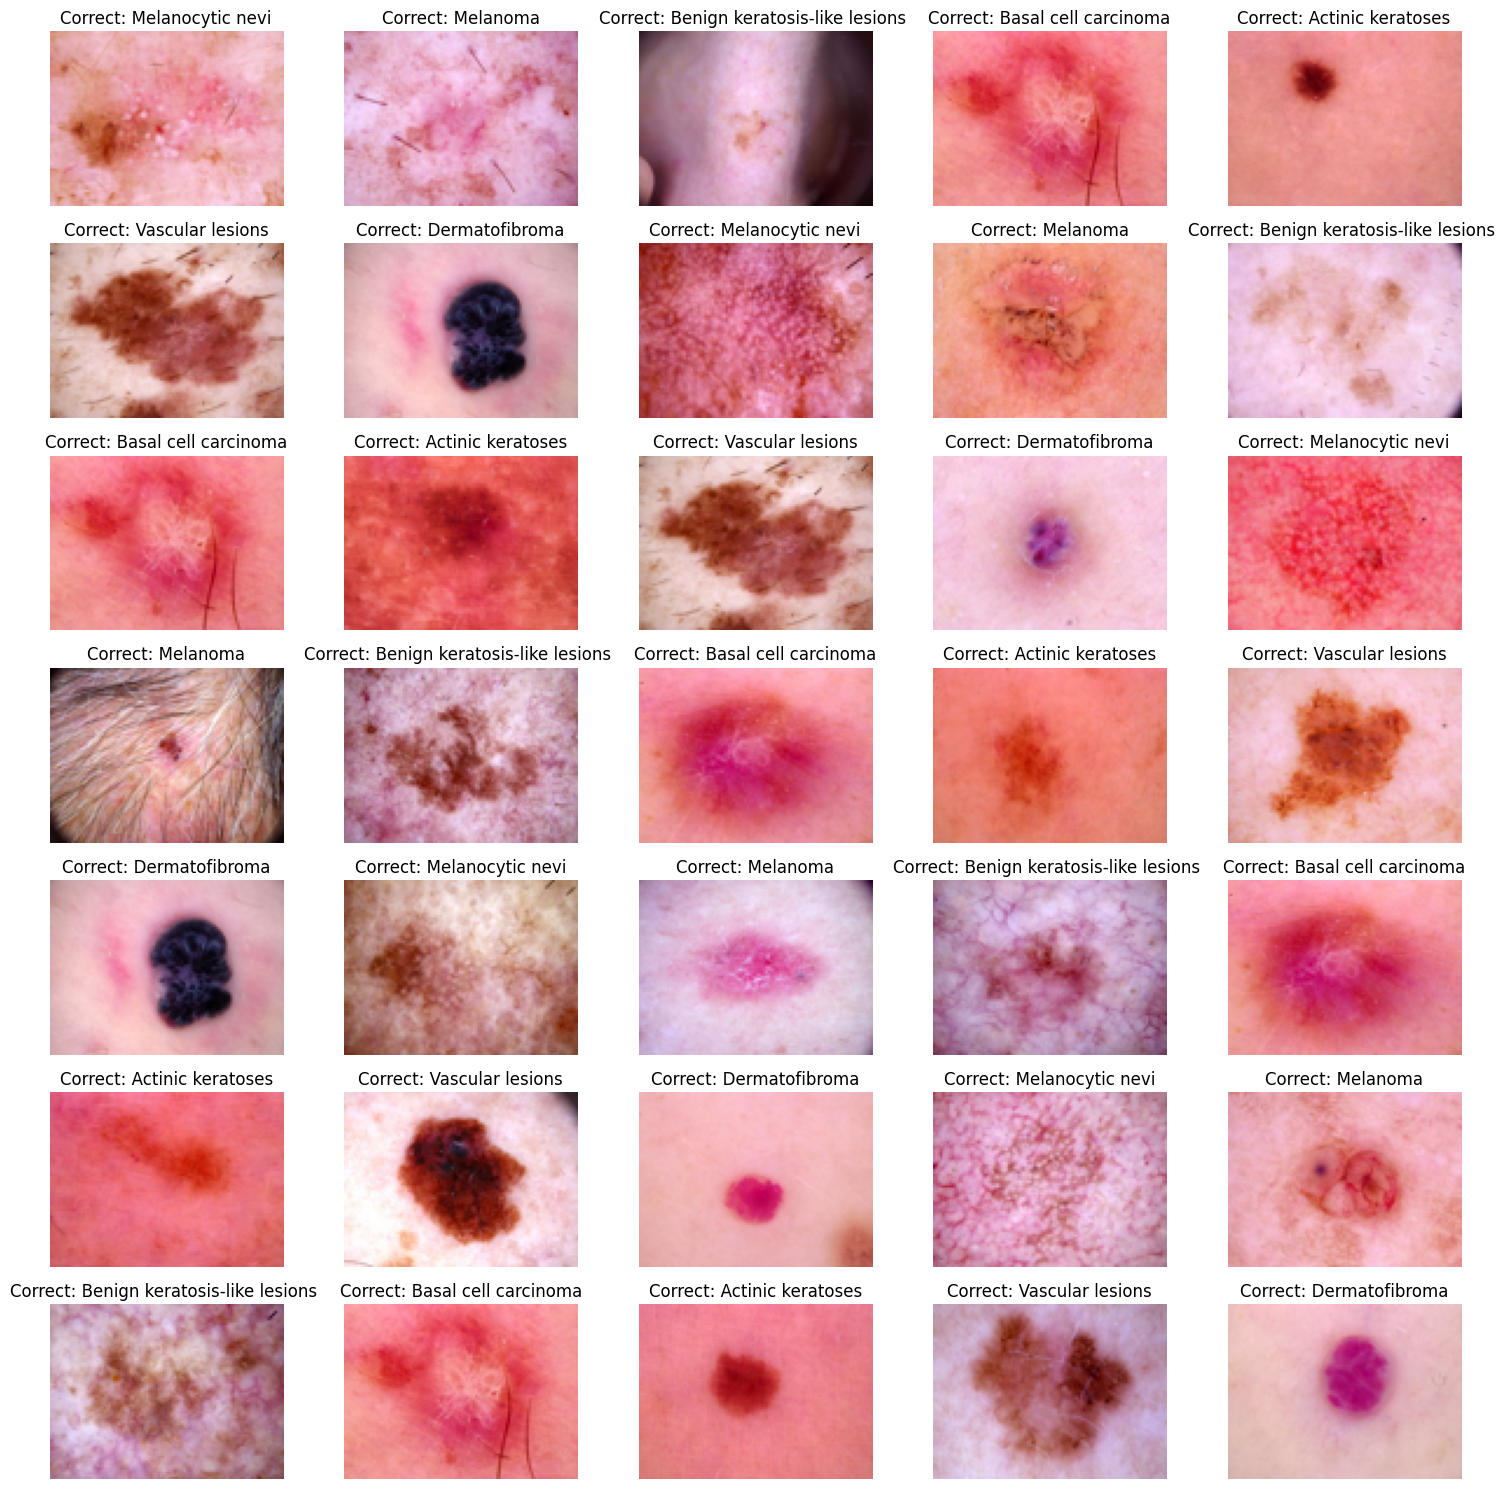

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate the scaler
scaler = MinMaxScaler()

# Get predicted probabilities
pred_probabilities = model.predict(x_test)

# Get predicted classes
pred_classes = np.argmax(pred_probabilities, axis=1)

# Get actual classes
actual_classes = np.argmax(y_test, axis=1)

# Identify correct and incorrect predictions
correct_indices = np.nonzero(pred_classes == actual_classes)[0]
incorrect_indices = np.nonzero(pred_classes != actual_classes)[0]

# Initialize subplot figure
fig, axes = plt.subplots(7, 5, figsize=(15, 15))

# To keep count of correct/incorrect predictions displayed
correct_count = np.zeros(7, dtype=np.int32)
incorrect_count = np.zeros(7, dtype=np.int32)

for idx, ax in enumerate(axes.flatten()):
    if correct_count.min() < 5:  # If less than 5 correct predictions per class displayed
        class_idx = correct_count.argmin()
        img_idx = np.random.choice(correct_indices[actual_classes[correct_indices] == class_idx])
        correct_count[class_idx] += 1
        ax.set_title(f"Correct: {list(lesion_type_dict.values())[class_idx]}")
    else:  # If less than 5 incorrect predictions per class displayed
        class_idx = incorrect_count.argmin()
        img_idx = np.random.choice(incorrect_indices[actual_classes[incorrect_indices] == class_idx])
        incorrect_count[class_idx] += 1
        ax.set_title(f"Incorrect: {list(lesion_type_dict.values())[class_idx]} predicted as {list(lesion_type_dict.values())[pred_classes[img_idx]]}")
    
    img = x_test[img_idx]
    # Flatten the image for the scaler, then reshape it back to its original shape
    img_normalized = scaler.fit_transform(img.reshape(-1, 1)).reshape(img.shape)
    ax.imshow(img_normalized)
    ax.axis('off')

plt.tight_layout()
plt.show()
